In [1]:
import sys
import os
import xarray as xr
import matplotlib.pyplot as plt
sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))    # So can access functions in isca_tools which is in home/Isca directory
import isca_tools
import numpy as np
from isca_tools.utils.land import get_ocean_coords, get_land_coords
from isca_tools.utils import area_weighting, lat_lon_slice

In [2]:
# Plot evolution of net flux and temperature to see how long it takes to spin up
def plot_spinup(ds_full, ds_ocean, ds_land, ax, albedo, tau):
    # Need to do area weighting so higher latitudes contribute less to reflect their area
    olr_sum = area_weighting(ds_full.olr).sum(dim = ['lon', 'lat'])
    short_wave_sum = area_weighting(ds_full.swdn_toa).sum(dim = ['lon', 'lat'])
    # Include surface albedo which reflects all SW radiation reaching it
    # SW radiation reaching it has been reduced by that absorbed in the atmosphere - non zero short wave optical depth.
    # There is no absorption on return trip from surface to space though hence just the one factor.
    net_flux = olr_sum - short_wave_sum*(1-albedo*np.exp(-tau))
    # net_flux = olr_sum - short_wave_sum
    net_flux.plot.line(ax=ax, color='b')
    ax.set_ylabel('TOA Net Outgoing FLux / $Wm^{-2}$\nOLR - (1-$\\alpha e^{-\\tau})SW$', color='b')
    t_ocean = area_weighting(ds_ocean.t_surf).mean(dim = ['location']) - 273.15  # In Celsius
    t_land = area_weighting(ds_land.t_surf).mean(dim = ['location']) - 273.15  # In Celsius
    ax2 = ax.twinx()
    t_ocean.plot.line(ax=ax2, color='r', label='Ocean')
    t_land.plot.line(ax=ax2, color='r', linestyle=':', label='Land')
    ax2.set_ylabel('Surface Temperature / $°C$', color='r')
    ax2.legend()


In [3]:
# Load dataset across all months for each depth value
exp_name = 'land/test'
dataset = isca_tools.load_dataset(exp_name)
namelist = isca_tools.load_namelist(exp_name)  # Need this for albedo_value
albedo = namelist['mixed_layer_nml']['albedo_value']
tau = namelist['two_stream_gray_rad_nml']['atm_abs']

In [6]:
# Get land and ocean datasets
import xarray as xr
namelist_file_name = os.path.join(namelist['experiment_details']['input_dir'], 'd5_namelist.nml')
land_lat, land_lon = get_land_coords(namelist_file_name)
ocean_lat, ocean_lon = get_ocean_coords(namelist_file_name)

ds_land = lat_lon_slice(dataset, land_lat, land_lon)
# Only consider ocean at same latitude range as land
ocean_lon = ocean_lon[np.where(np.abs(ocean_lat)<=land_lat.max())[0]]
ocean_lat = ocean_lat[np.where(np.abs(ocean_lat)<=land_lat.max())[0]]
ds_ocean = lat_lon_slice(dataset, ocean_lat, ocean_lon)

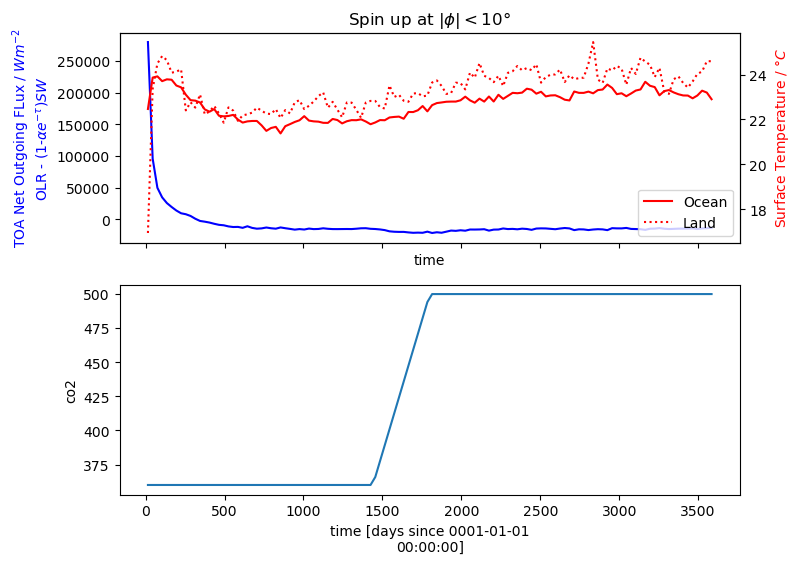

In [7]:
# Plot spinup time for each depth value
fig, ax = plt.subplots(2,1, figsize=(8, 6), sharex=True)
plot_spinup(dataset, ds_ocean, ds_land, ax[0], albedo, tau)
ax[0].set_title(f"Spin up at $|\phi|<10\degree$")

# Indicate time when CO2 concentration starts to increase
dataset.co2.sum(dim = ['scalar_axis']).plot.line(ax=ax[1]);